In [1]:
import os
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_dir = 'ap_images/data'
input_shape = 224
mean = [0.5, 0.5, 0.5]
std = [0.5, 0.5, 0.5]

#data transformation
data_transforms = {
   'train': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
   'validation': transforms.Compose([
       transforms.CenterCrop(input_shape),
       transforms.ToTensor(),
       transforms.Normalize(mean, std)
   ]),
}

In [3]:
image_datasets = {
   x: datasets.ImageFolder(
       os.path.join(data_dir, x),
       transform=data_transforms[x]
   )
   for x in ['train', 'validation']
}

dataloaders = {
   x: torch.utils.data.DataLoader(
       image_datasets[x], batch_size=32,
       shuffle=True, num_workers=4
   )
   for x in ['train', 'validation']
}

In [4]:
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'validation']}

print(dataset_sizes)
class_names = image_datasets['train'].classes

{'train': 694, 'validation': 200}


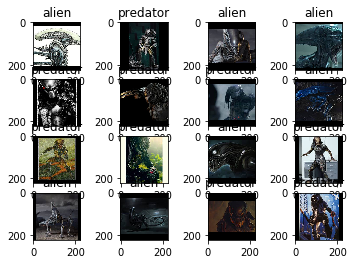

In [5]:
images, labels = next(iter(dataloaders['train']))

rows = 4
columns = 4
fig=plt.figure()
for i in range(16):
    fig.add_subplot(rows, columns, i+1)
    plt.title(class_names[labels[i]])
    img = images[i].numpy().transpose((1, 2, 0))
    img = std * img + mean
    plt.imshow(img)
plt.show()

In [6]:
## Load the model based on VGG19
vgg_based = torchvision.models.vgg19(pretrained=True)

## freeze the layers
for param in vgg_based.parameters():
    param.requires_grad = False

# Modify the last layer
number_features = vgg_based.classifier[6].in_features
 # Remove last layer
features = list(vgg_based.classifier.children())[:-1]
features.extend([torch.nn.Linear(number_features, len(class_names))])
vgg_based.classifier = torch.nn.Sequential(*features)

# vgg_based = vgg_based.to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer_ft = optim.SGD(vgg_based.parameters(), lr=0.001, momentum=0.9)

In [7]:
def train_model(model, criterion, optimizer, num_epochs=2):

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

       #set model to trainable
       # model.train()

        train_loss = 0

       # Iterate over data.
        for i, data in enumerate(dataloaders['train']):
            inputs , labels = data
#             inputs = inputs.to(device)
#             labels = labels.to(device)

            optimizer.zero_grad()
          
            with torch.set_grad_enabled(True):
                outputs  = model(inputs)
                loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            train_loss += loss.item() * inputs.size(0)

            print('{} Loss: {:.4f}'.format(
               'train', train_loss / dataset_sizes['train']))
          
    #print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

    return model

In [8]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['validation']):
#             inputs = inputs.to(device)
#             labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {} truth: {}'.format(class_names[preds[j]], class_names[labels[j]]))
                img = inputs.cpu().data[j].numpy().transpose((1, 2, 0))
                img = std * img + mean
                ax.imshow(img)

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

Epoch 0/1
----------
train Loss: 0.0325
train Loss: 0.0650
train Loss: 0.0907
train Loss: 0.1197
train Loss: 0.1449
train Loss: 0.1705
train Loss: 0.1903
train Loss: 0.2143
train Loss: 0.2339
train Loss: 0.2605
train Loss: 0.2769
train Loss: 0.2932
train Loss: 0.3056
train Loss: 0.3188
train Loss: 0.3329
train Loss: 0.3520
train Loss: 0.3688
train Loss: 0.3810
train Loss: 0.3996
train Loss: 0.4090
train Loss: 0.4235
train Loss: 0.4355
Epoch 1/1
----------
train Loss: 0.0167
train Loss: 0.0256
train Loss: 0.0350
train Loss: 0.0458
train Loss: 0.0583
train Loss: 0.0694
train Loss: 0.0802
train Loss: 0.0903
train Loss: 0.1053
train Loss: 0.1186
train Loss: 0.1236
train Loss: 0.1286
train Loss: 0.1408
train Loss: 0.1599
train Loss: 0.1718
train Loss: 0.1859
train Loss: 0.1926
train Loss: 0.2009
train Loss: 0.2136
train Loss: 0.2329
train Loss: 0.2457
train Loss: 0.2536


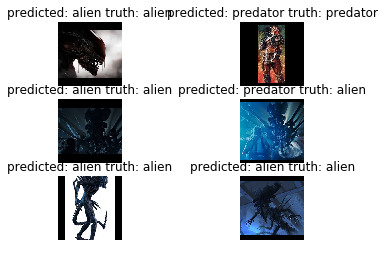

In [9]:
vgg_based = train_model(vgg_based, criterion, optimizer_ft, num_epochs=2)

visualize_model(vgg_based)

plt.show()